# What is RFM Analysis?
RFM analysis is a data-driven marketing technique used by businesses to segment and analyze their customer base. It helps businesses understand and categorize customers based on their historical behavior and purchase patterns.

The acronym “RFM” stands for:

Recency (R): This factor assesses how recently a customer has made a purchase or interacted with the business. Customers who have made a purchase more recently are considered more valuable because they are more likely to make future purchases. Recency is often measured in terms of the number of days, weeks, or months since the last transaction or interaction.


Frequency (F): Frequency measures how often a customer has made purchases or engaged with the business over a specific period. Customers who make frequent purchases are often more loyal and valuable to the business. Frequency can be calculated by counting the number of transactions or interactions within a given time frame.


Monetary Value (M): Monetary value or monetary contribution represents the total amount of money a customer has spent on the business’s products or services. Customers who have spent more money are typically considered more valuable. This can be measured as the sum of all the customer’s purchases or transactions.

In [101]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from fastapi import Depends, FastAPI, HTTPException
import pathlib
import seaborn as sns
import datetime as dt
import dask.array as da
from pathlib import Path
from icecream import ic
import  traceback
from datetime import datetime

In [102]:
df=pd.read_csv("feb.csv")

In [103]:
 #print(df.head()) 

In [104]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302031 entries, 0 to 302030
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   msisdn      302031 non-null  int64  
 1   cdr_date    302031 non-null  object 
 2   product_id  302031 non-null  int64  
 3   total_amt   302031 non-null  float64
 4   total_cnt   302031 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 11.5+ MB


In [105]:
df.describe()

,msisdn,product_id,total_amt,total_cnt
count,3.020310e+05,302031.000000,302031.000000,302031.000000
mean,1.134334e+11,6543.116607,30.417720,1.034139
std,4.715110e+11,1316.901089,101.548401,0.215197
min,2.672000e+10,3958.000000,0.004000,1.000000
25%,2.677341e+10,6335.000000,5.000000,1.000000
50%,2.677370e+10,6451.000000,5.000000,1.000000
75%,2.677397e+10,7968.000000,15.000000,1.000000
max,2.678901e+12,7976.000000,1630.000000,13.000000


# Data Preprocessing


In [106]:
df = df.dropna()  


In [107]:
last_purchase_dates = df.groupby('msisdn')['cdr_date'].max().reset_index()
df1 = df.merge(last_purchase_dates, on=['msisdn', 'cdr_date'], how='inner')
#print(df1)

# RFM Calculation

### Recency Value Calculation

In [108]:
df['cdr_date'] = pd.to_datetime(df1['cdr_date'])

In [109]:
today = datetime.strptime('2024-02-29', '%Y-%m-%d')

In [110]:
df1['recency'] = (today - df['cdr_date']).dt.days
df1['recency'] = df1['recency'].astype(int)
#print(df1[['msisdn','product_id', 'recency']])
#df1

### Frequency and Monetary Value Calculation

In [111]:
agg_dict1 = {
    'product_id': 'count',
    'total_amt': 'sum'
}
df_rfm = df.groupby('msisdn').agg(agg_dict1).reset_index()
df_rfm.columns = ['msisdn', 'frequency', 'monetary']
#print(df_rfm)


# RFM Score Calculation

In [112]:
rfm = pd.merge(df_rfm, df1[['msisdn','product_id', 'recency']], on='msisdn')
#rfm

In [113]:
# Calculate R score
rfm['r_score'] = pd.qcut(rfm['recency'], q=5, labels=['5', '4', '3', '2', '1'])

In [114]:
# Calculate M score
rfm['m_score'] = pd.qcut(rfm['monetary'], q=5, labels=['1', '2', '3', '4', '5'], duplicates='drop')

In [115]:
# Calculate F score

rfm['f_score'] = pd.qcut(rfm ['frequency'], q=4, labels=['1', '2', '3'], duplicates='drop')

In [116]:
#rfm

### RFM Score Calculation

In [117]:
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

In [118]:
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']
#rfm['rfm_score']

### RFM Value Segmentation

In [119]:
segment_labels=['Low-Value','Mid-Value','High-Value']
rfm['Value Segment']=pd.qcut(rfm['rfm_score'],q=3,labels=segment_labels)

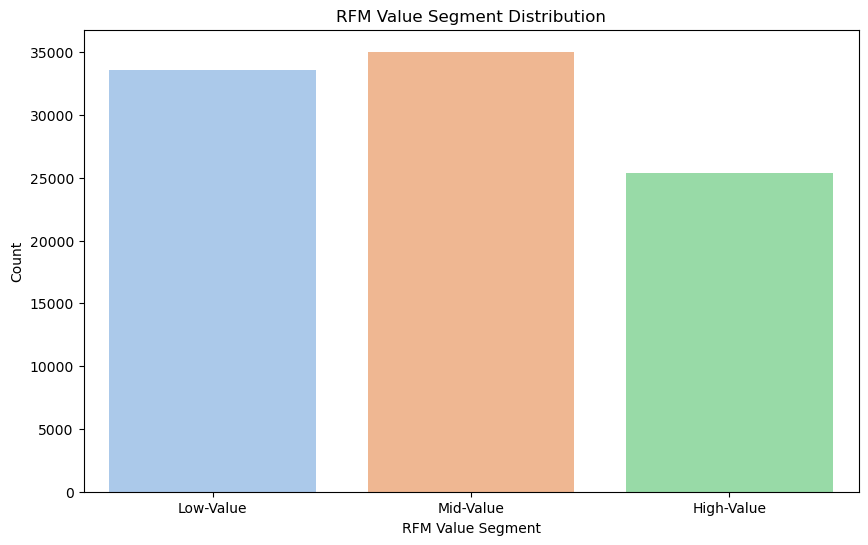

In [120]:
# Create the bar plot
segment_counts = rfm['Value Segment'].value_counts().reset_index()
segment_counts.columns = ['Value Segment', 'Count']
pastel_colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Value Segment', y='Count', palette=pastel_colors)
plt.title('RFM Value Segment Distribution')
plt.xlabel('RFM Value Segment')
plt.ylabel('Count')
plt.grid(False)
plt.show()


#### RFM Customer Segmentation

In [121]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [122]:
rfm['rfm_label'] = ''

rfm = assign_label(rfm, (5,5), (4,5), 'champions')
rfm = assign_label(rfm, (3,4), (4,5), 'loyal customers')
rfm = assign_label(rfm, (4,5), (2,3), 'potential loyalist')

rfm = assign_label(rfm, (5,5), (1,1), 'new customers')
rfm = assign_label(rfm, (4,4), (1,1), 'promising')
rfm = assign_label(rfm, (3,3), (3,3), 'needing attention')
rfm= assign_label(rfm, (3,3), (1,2), 'about to sleep')
rfm = assign_label(rfm, (1,2), (3,4), 'at risk')
rfm = assign_label(rfm, (1,2), (5,5), 'cant loose them')
rfm = assign_label(rfm, (1,2), (1,2), 'hibernating')
print(rfm['rfm_label'])

0               hibernating
1            about to sleep
2        potential loyalist
3               hibernating
4        potential loyalist
                ...        
94010           hibernating
94011           hibernating
94012           hibernating
94013           hibernating
94014           hibernating
Name: rfm_label, Length: 94015, dtype: object


In [123]:
max_rfm_score = rfm['rfm_score'].max()
min_rfm_score = rfm['rfm_score'].min()
print(f"Maximum RFM Score: {max_rfm_score}")
print(f"Minimum RFM Score: {min_rfm_score}")


Maximum RFM Score: 13
Minimum RFM Score: 3


In [129]:
# Define the function to categorize RFM segments
def cluster_segments(rfm):
    if rfm.rfm_score > 9:
        return 'Champions'
    elif 6 <= rfm.rfm_score <= 9:
        return 'Potential Loyalists'
    elif 5 <= rfm.rfm_score < 6:
        return 'At-Risk'
    elif 4 <= rfm.rfm_score < 5:
        return 'Cannot Lose'
    else:
        return 'Lost'

# Apply the function to the DataFrame
rfm['RFM Customer Segments'] = rfm.apply(cluster_segments, axis=1)

# Display the DataFrame with the new column
print(rfm)


              msisdn  frequency  monetary  product_id  recency  r_score  \
0        26720000040          1     560.0        7043       15        2   
1        26773000010          3      81.0        6336        9        3   
2        26773000018          7      75.0        3958        0        5   
3        26773000073          2      66.0        3959       15        2   
4        26773000074          4     220.0        7975        0        5   
...              ...        ...       ...         ...      ...      ...   
94010  2678900699984          1     560.0        7043       14        2   
94011  2678900699994          1     560.0        7043       27        1   
94012  2678900699997          1     560.0        7043       27        1   
94013  2678900699998          1     560.0        7043       21        1   
94014  2678900699999          1     560.0        7043       19        2   

       m_score  f_score  rfm_score Value Segment  rfm_label  \
0            5        1          8  

### RFM Analysis

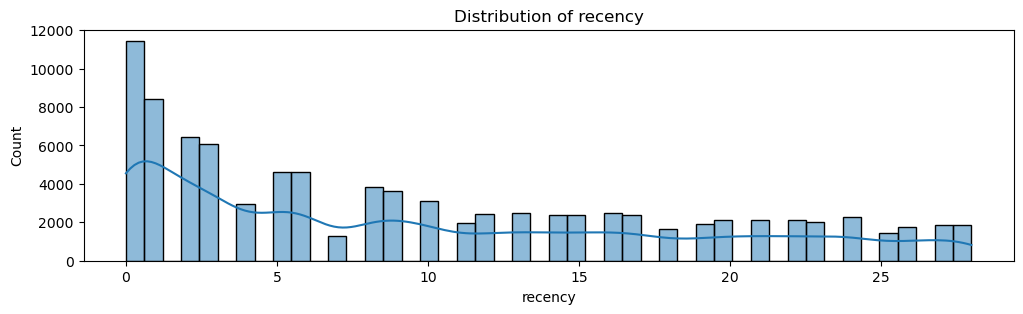

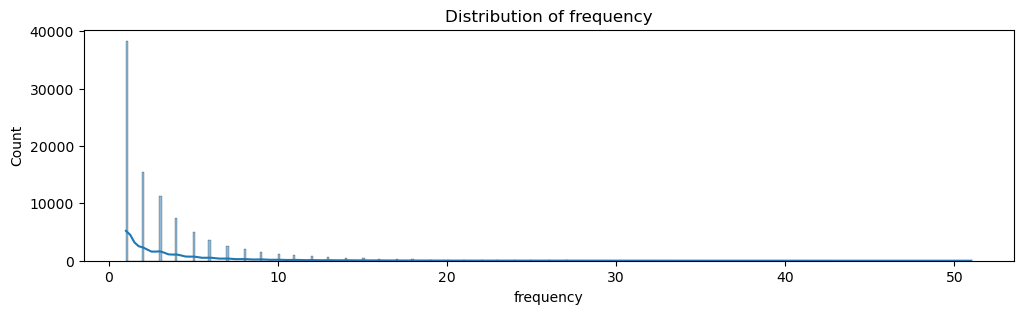

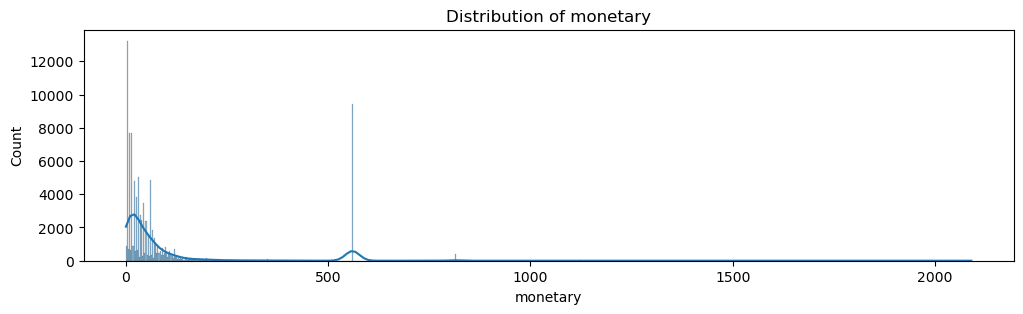

In [125]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.histplot(rfm[col], kde=True, ax=ax)
    ax.set_title('Distribution of %s' % col)
    plt.show()

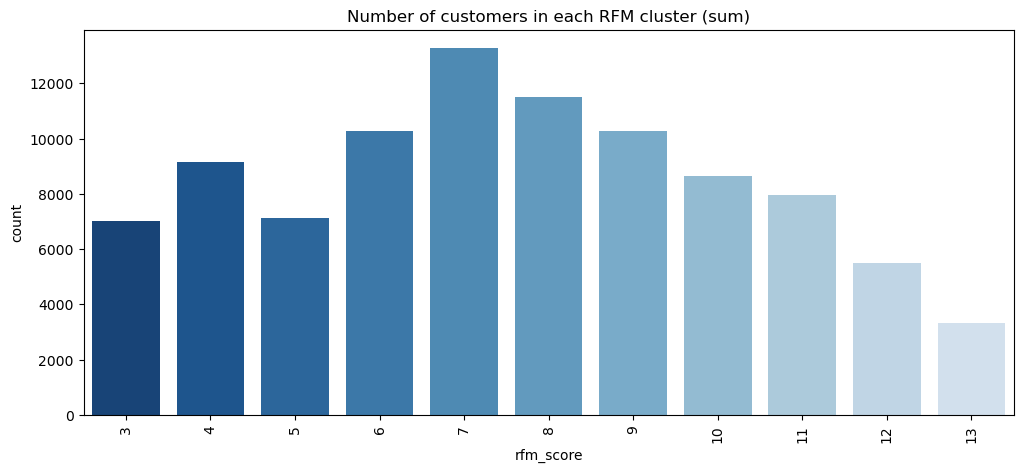

In [126]:
palette = sns.color_palette("Blues_r", n_colors=13)

# Ensure 'rfm_label' column exists and is correct
rfm['rfm_label'] = rfm['rfm_score']  # Assuming rfm_score is already calculated

# Plot distribution of RFM labels
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x='rfm_score', data=rfm, palette=palette)
ax.set_title('Number of customers in each RFM cluster (sum)')
plt.xticks(rotation=90)
plt.show()

### RFM Customer Champion Segments by Value (Box Plot)



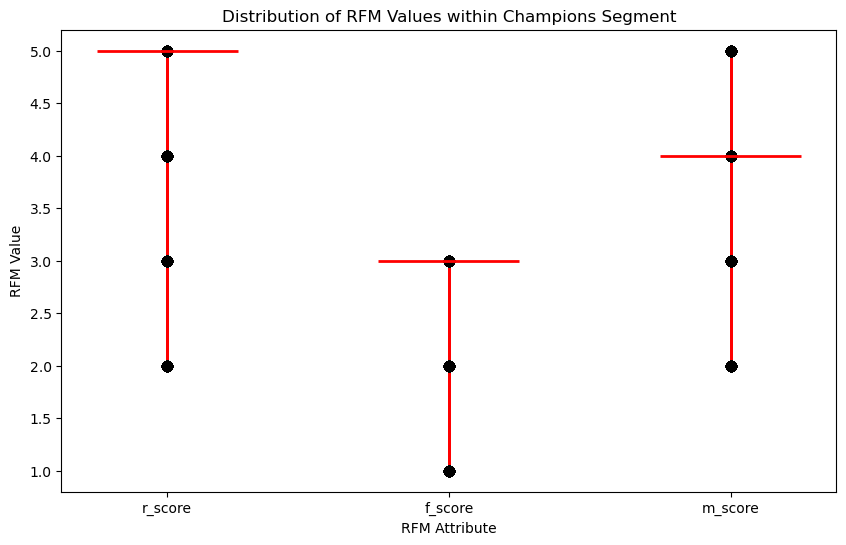

In [127]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Distribution of RFM Values within Champions Segment')
ax.set_xlabel('RFM Attribute')
ax.set_ylabel('RFM Value')

required_columns = ['r_score', 'f_score', 'm_score']

# Filter the DataFrame for the Champions segment
champions_segment = rfm[rfm['RFM Customer Segments'] == 'Champions']

for i, column in enumerate(required_columns):
    y_values = champions_segment[column].astype(float)
    x_positions = np.full(len(y_values), i)
    ax.scatter(x_positions, y_values, marker='o', color='black', s=50, zorder=3)
    ax.vlines(x_positions, ymin=y_values.min(), ymax=y_values.max(), color='r', linewidth=2, zorder=2)
    ax.hlines(y=y_values.median(), xmin=i-0.25, xmax=i+0.25, color='r', linewidth=2, zorder=4)

ax.set_xticks(range(len(required_columns)))
ax.set_xticklabels(required_columns)
ax.grid(False)


plt.show()

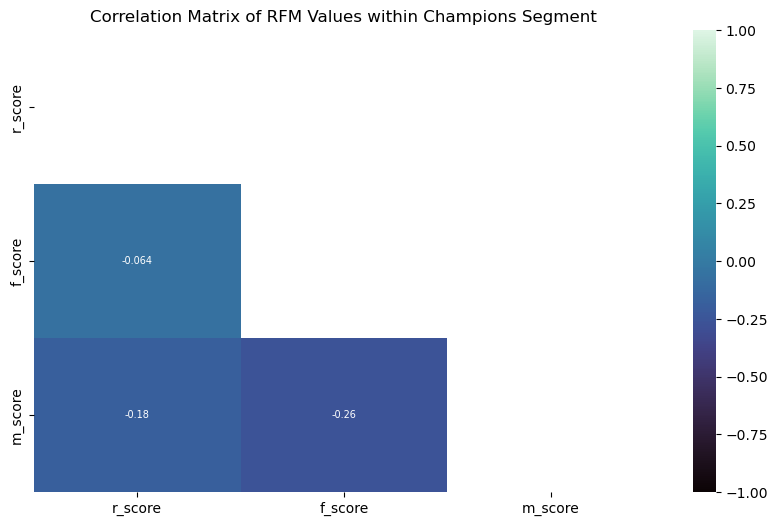

In [128]:
champions_segment = rfm[rfm['RFM Customer Segments'] == 'Champions']

# Plot the correlation matrix
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Correlation Matrix of RFM Values within Champions Segment')

# Calculate the correlation matrix
corr = champions_segment[['r_score', 'f_score', 'm_score']].astype(float).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, vmin=-1, vmax=1, cmap='mako', annot=True, mask=mask, annot_kws={"fontsize": 7})

plt.grid(False)
plt.show()

# Summary:
    
The correlation matrix heatmap provides a visual representation of the relationships between recency, frequency, and monetary scores for the "Champions" customer segment.

The weak negative correlations suggest that within this group:
More recent purchases are slightly associated with lower frequency and monetary values.
Higher frequency of purchases is weakly associated with lower monetary values.
Overall, these insights can help understand the purchasing behavior of the "Champions" segment and guide targeted marketing or customer engagement strategies.






